In [15]:
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from mpmath import *
from matplotlib.pyplot import figure, show, rc
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [16]:
def rotation(phi, theta, psi):
    
    def B2(angle):
        
        B2 = np.zeros((3,3))
        
        B2[0, 0] = np.cos(angle)
        B2[0, 2] = np.sin(angle)
        B2[1, 1] = 1
        B2[2, 0] = -np.sin(angle)
        B2[2, 2] = np.cos(angle)
        
        B2 = np.asmatrix(B2)
        
        return B2
    
    def B3(angle):
        
        B3 = np.zeros((3,3))
        
        B3[0, 0] = np.cos(angle)
        B3[0, 1] = -np.sin(angle)
        B3[1, 0] = np.sin(angle)
        B3[1, 1] = np.cos(angle)
        B3[2, 2] = 1
        
        return B3
    
    R = B3(psi)*B2(theta)*B3(phi)
    
    return R
        
        

In [17]:
def rodriguez(vector, rotationangle):
    
    W = np.zeros((3,3))
    
    W[0, 1] = -vector[2]
    W[0, 2] = vector[1]
    W[1, 0] = vector[2]
    W[1, 2] = -vector[0]
    W[2, 0] = -vector[1]
    W[2, 1] = vector[0]
    W = np.asmatrix(W)
    
    R = np.eye(3)+np.sin(rotationangle)*W+(2*(np.sin(rotationangle/2)**2)*W*W)
    
    return R

In [18]:
def fault_orientation_matrix(phiF, thetaF, lamda):

    Rstrike_fault = np.zeros((3,3))
    Rstrike_fault[0, 0] = np.cos(phiF)
    Rstrike_fault[0, 1] = -np.sin(phiF)
    Rstrike_fault[1, 0] = np.sin(phiF)
    Rstrike_fault[1, 1] = np.cos(phiF)
    Rstrike_fault[2, 2] = 1
    Rstrike_fault = np.asmatrix(Rstrike_fault)

    Rdip_fault = np.zeros((3, 3))

    Rdip_fault[0 , 0] = 1
    Rdip_fault[1, 1] = np.cos(thetaF)
    Rdip_fault[1, 2] = np.sin(thetaF)
    Rdip_fault[2, 1] = -(np.sin(thetaF))
    Rdip_fault[2, 2] = np.cos(thetaF)
    Rdip_fault = np.asmatrix(Rdip_fault)

    rakeaxis = (Rstrike_fault)*(Rdip_fault)*np.matrix('0; 0 ; 1')

    rakeaxis = np.array(rakeaxis).flatten()

    Rrake_fault = rotationmat3D(lamda, rakeaxis)

    Faultorientation = (Rrake_fault)*(Rstrike_fault)*(Rdip_fault)


    return Faultorientation


In [19]:
def stressorientation_matrix(phi_MCS, theta_MCS, rho_MCS=0):

    
    B = rotation(phi_MCS, theta_MCS, 0)
    rho_axis = B*np.matrix([1, 0, 0]).T
    R_rho = rodriguez(rho_axis, rho_MCS)
    
    StressOrienation = R_rho*B
    

    return StressOrientation
    

In [20]:
def Resolve_StressTensorOnFault(pstress, sangle, fangle):


    S1 = pstress[0]
    S2 = pstress[1]
    S3 = pstress[2]


    # fangle = [Fault_Strike, Fault_dip, Fault_rake]
    # phiF = Fault_Strike, thetaF = Fault_dip, rakeF = Fault_rake
    # if dealing with principal stresses

    phiF = fangle[0]
    thetaF = fangle[1]
    rakeF = fangle[2]


    if pstress.shape == (3,3):

        stressDirection = pstress

    else:

        phi_MCS = sangle[0]
        theta_MCS = sangle[1]
        theta_ICS = sangle[2]

        #define the principal stress tensor
        Sprincipal = np.array(([S1, 0, 0,], [0, S2, 0], [0, 0, S3]))

        #------Stress Geographic
        stressRotation = stressorientation_matrix(phi_MCS, theta_MCS, theta_ICS)

        stressDirection = stressRotation*Sprincipal*stressRotation.T

        A = (stressDirection.T + stressDirection) / 2

        #diagonlized tensor is too differnt from origianl

    if np.amax(np.abs(A[:]-stressDirection[:]))> (1e3*np.spacing(1)):
        SigmaN = 0
        Tau_rake_parallel = 0
        Tau_rake_perpendicular = 0
        D = np.identity(3)
        V = np.identity(3)
        #diagnolized tensor is negligibly different from the original

    else:
        stressDirection = A
        stressDirection = np.transpose(stressDirection)
        #compute the principal directions
        D, V = np.linalg.eig(stressDirection)

    #-----Stress on a fault

    # rotation matrix for a fault plane
        faultRotation = fault_orientation_matrix(phiF, thetaF, rakeF)

        #Rotate stress onto fault plane
        stressOnFault = np.transpose(faultRotation)*stressDirection*faultRotation
        SigmaN = stressOnFault[2, 2]
        Tau_rake_parallel = stressOnFault[0,2]
        Tau_rake_perpendicular = stressOnFault[1, 2]

        return SigmaN, Tau_rake_parallel, Tau_rake_perpendicular, D, V


In [21]:
def Resolve_ShearStressDir(pstress, sangle, fangle):
    #Notes:
    #Calculate value of FaultRake = arctan(Tau_S/Tau_D)
    #Calculate Tau_rake_parallel (shear slip in direction of fault rake)
    # In this function Tau_D and Tau_S seem like the equivalent of TRParallel
    # and TRPerpendicular in Resolve_StressTensorOnFault
    #End Notes

    #Ensures input fault rake = 0

    if len(fangle) == 3:
    
        if fangle[2] != 0:
        
            print('Changing Non-Zero Rake to Zero')
            fangle[2] = 0
    
    elif len(fangle) == 2: #If there are only two elements, add a third element that is 0
        
        np.append(fangle, 0)

    #Using function "Stress_onFault" to determine Tau_{d} and Tau_{s}
    SigmaN, TauDip, TauStrike, D, V = Resolve_StressTensorOnFault(pstress, sangle, fangle)

    #Calculate the fault rake

    RakeCalc = np.arctan2(TauStrike, TauDip) * (180/np.pi)

    #Calculate Chear Slip in the Rake Direction

    Tau_rake_parallel = TauDip/np.cos(np.deg2rad(RakeCalc))

    return RakeCalc


In [22]:
def sample_vMF(mu, kappa, nsteps):

    #This function generates a random m-vector on an n-sphere
    #Output is in cartesian coordinates
    dimension = len(mu)
    rand_vec = np.zeros((nsteps, dimension))
    for i in range(nsteps):

        # generate a sample off of the mean direction given a concetration kappa

        w = _sample_weight(kappa, dimension)

        # sample a point v on the unit sphere that's orthogonal to mu
        v = _sample_orthonormal_to(mu)

        # compute new point
        rand_vec[i, :] = v * np.sqrt(1. - w**2) + w * mu

    return rand_vec

def _sample_weight(kappa, dimension):

    S = dimension - 1
    b = (-2*kappa+(4*kappa**2+(S)**2)**(1/2))/(S)
    x = (1. - b) / (1. + b)
    c = kappa * x + S * np.log(1 - x**2)

    while True:
        z = np.random.beta(S / 2, S / 2)
        w = (1 - (1 + b) * z) / (1 - (1 - b) * z)
        u = np.random.uniform(0, 1)
        if kappa * w + S * np.log(1. - x * w) - c >= np.log(u):
            return w

def _sample_orthonormal_to(mu):

    v = np.random.randn(mu.shape[0])
    proj_mu_v = mu * np.dot(mu, v) / np.linalg.norm(mu)
    orthto = v - proj_mu_v
    return orthto / np.linalg.norm(orthto)

In [23]:
def cartesian2spherical(cartesian_coords):

    spherical_coords = np.zeros(cartesian_coords.shape)
   
    for i in range(len(cartesian_coords)):
        
        #radius

        spherical_coords[i,0] = np.sqrt(np.sum(cartesian_coords[i, :]**2)) 
        
        #angle 1
        
        spherical_coords[i, 1] = np.arccos(cartesian_coords[i, 0]/spherical_coords[i, 0])
        
        #angle 2
        
        spherical_coords[i, 2] = np.arccos(cartesian_coords[i, 1]/(np.sqrt(cartesian_coords[i, 3]**2+cartesian_coords[i, 2]**2+cartesian_coords[i, 1]**2)))
        
        #angle 3
        
        if cartesian_coords[i, 3] >= 0:
            
            spherical_coords[i, 3] = np.arccos(cartesian_coords[i, 2]/(np.sqrt(cartesian_coords[i,3]**2+cartesian_coords[i, 2]**2)))
            
        else:
            
            spherical_coords[i, 3] = 2*np.pi-np.arccos(cartesian_coords[i, 2]/(np.sqrt(cartesian_coords[i,3]**2+cartesian_coords[i, 2]**2)))
            
            
        return spherical_coords


In [24]:
def spherical2cartesian(spherical_coords):

    if spherical_coords.shape == (3,):
    
        spherical_coords = spherical_coords.reshape((3,1))
        
    cartesian_coords = np.zeros(spherical_coords.shape)

    for i in range(len(cartesian_coords)):

        r = spherical_coords[i, 0]
        angle1 = spherical_coords[i, 1]
        angle2 = spherical_coords[i, 2]
        angle3 = spherical_coords[i, 3]

        cartesian_coords[i, 0] = r*np.cos(angle1)
        cartesian_coords[i, 1] = r*np.sin(angle1)*np.cos(angle2)
        cartesian_coords[i, 2] = r*np.sin(angle1)*np.sin(angle2)*np.cos(angle3)
        cartesian_coords[i, 3] = r*np.sin(angle1)*np.sin(angle2)*np.sin(angle3)

    return cartesian_coords


In [ ]:
sangle = np.array([np.pi/4, ])


In [9]:
#Define fault parameters and number of faults

pstress = np.array([-1, -1/2, -1/4])
number_of_faults = 1

fangle = np.zeros((number_of_faults, 3))
observed_rake = np.zeros((1, number_of_faults))


#Define Fault Orientation; do not include rake; make sure angles are in rads
fault1 = np.array([np.pi/4, np.pi/6, 0 ])
fangle[0, :] = fault1




#Define observed rake for each fault; make sure rake is in degrees
observed_rake[0, 0] = 32.7
print(observed_rake)





#Define random walk parameters

n_steps = 10**6
kappa = 0
mu_initial = np.array([0, 0, 0, 1])
calculated_rakes = np.zeros((n_steps, number_of_faults))
residual = np.zeros((n_steps, number_of_faults))
likelihood = np.zeros((n_steps, 1))

#Steps are in cartesian coordinates, model parameters are in spherical
steps = np.zeros((n_steps, len(mu_initial)))
model_parameters = np.zeros((n_steps,3))


NameError: name 'np' is not defined

In [10]:
for i in range(n_steps):
    
    
    if i == 0:
        
        initial_step = sample_vMF(mu_initial, kappa, 1)
        
        steps[i] = initial_step
        
        model_params = cartesian2spherical(initial_step).flatten()
        
        model_parameters[i] = model_params[1:]
        
        
        for j in range(number_of_faults):
            
            fault_orientation = fangle[j, :]
        
        
            rake_estimated = Resolve_ShearStressDir(pstress, model_parameters[i], fault_orientation)
            

            
            calculated_rakes[i, j] = rake_estimated

            
            
            angle_difference = (observed_rake[0, j] - rake_estimated)
            
            
            residual[i, j] = np.cos(angle_difference*np.pi/180)
       
            
        

        
        likelihood[i] = np.exp(np.sum(residual))
        
    else:
        
        
        mu = steps[i-1]
        
        

        step = sample_vMF(mu, kappa, 1)

        

        model_params = cartesian2spherical(step).flatten()
        
        possible_model_params_step = model_params[1:][::-1]
        

        
 
        
        for j in range(number_of_faults):
                
            
            fault_orientation = fangle[j, :]
        
        
            rake_estimated = Resolve_ShearStressDir(pstress, possible_model_params_step, fault_orientation)
            
            

            
            calculated_rakes[i, j] = rake_estimated

            
            
            angle_difference = (observed_rake[0, j] - rake_estimated)
            
            
            
            residual[i, j] = np.cos(angle_difference*np.pi/180)
       
        
        likelihood_current_step = np.exp(np.sum(residual[i, :]))   
        LR = likelihood_current_step/likelihood[i-1]
        random_number = np.random.random()
        
        
        
        if LR >= random_number:
                

                
                likelihood[i] = likelihood_current_step
                
                model_parameters[i] = possible_model_params_step
                
                steps[i] = step

        else:        
                
                
                likelihood[i] = likelihood[i-1]
                
                calculated_rakes[i, :] = calculated_rakes[i-1, :]
                
                model_parameters[i] = model_parameters[i-1]
                
                steps[i] = steps[i-1]
        


        
  
        

        
        
        

        


NameError: name 'n_steps' is not defined

In [11]:
x = model_parameters[:, 0]*180/np.pi

y = model_parameters[:, 1]*180/np.pi
z = model_parameters[:, 2]*180/np.pi

NameError: name 'model_parameters' is not defined

In [12]:
plt.hexbin(x,y)
plt.xlabel('phi_MCS')
plt.ylabel('theta_MCS')

cb = plt.colorbar()
plt.savefig('w1.png')

plt.show()


NameError: name 'plt' is not defined

In [13]:
plt.hexbin(x,z)
plt.xlabel('phi_MCS')

plt.ylabel('theta_ICS')

cb = plt.colorbar()
plt.savefig('w2.png')

plt.show()

NameError: name 'plt' is not defined

In [14]:
plt.hexbin(y,z)
plt.xlabel('theta_MCS')
plt.ylabel('theta_ICS')


cb = plt.colorbar()
plt.savefig('w3.png')

plt.show()

NameError: name 'plt' is not defined

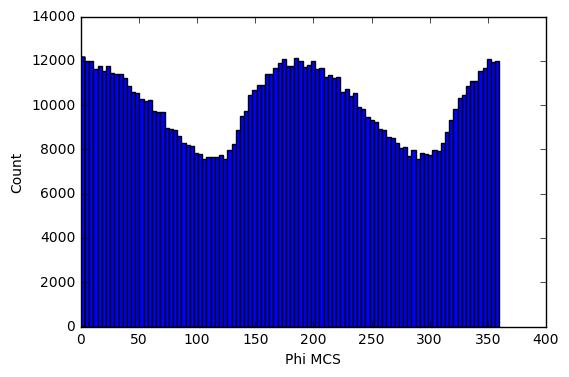

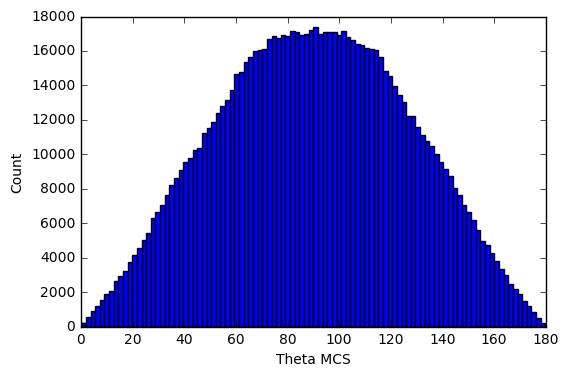

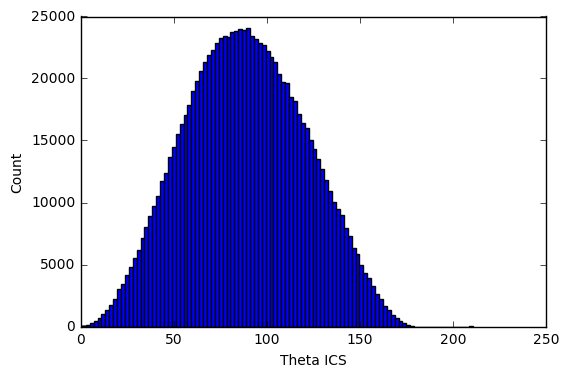

In [34]:
plt.hist(x, bins=100)
plt.xlabel('Phi MCS')
plt.ylabel('Count')
plt.savefig('w4.png')


plt.show()

plt.hist(y, bins=100)
plt.xlabel('Theta MCS')
plt.ylabel('Count')
plt.savefig('w5.png')


plt.show()

plt.hist(z, bins=100)
plt.xlabel('Theta ICS')
plt.ylabel('Count')
plt.savefig('w6.png')


plt.show()


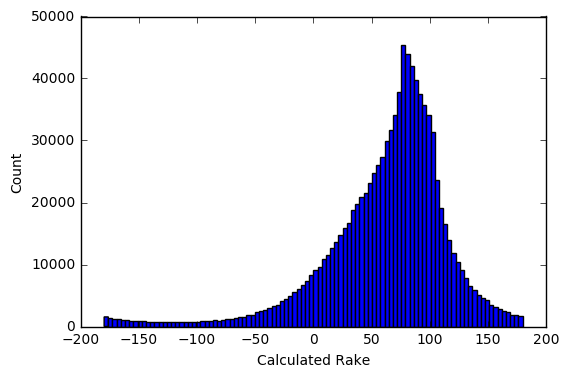

In [35]:
plt.hist(calculated_rakes, bins=100)
plt.xlabel('Calculated Rake')
plt.ylabel('Count')
plt.savefig('w7.png')

plt.show()

In [36]:
np.mean(calculated_rakes)


62.17630574496345

In [37]:
np.mean(x)


178.09896771238562

In [38]:
np.mean(calculated_rakes)

62.17630574496345